# Aula 10

# Trabalhando com o PySpark


### Introdução


Usaremos o conjunto de dados relacionado a campanhas de marketing direto (chamadas telefônicas) de uma instituição bancária. O objetivo da classificação é prever se o cliente irá realizar (Sim/Não) um depósito a prazo. O conjunto de dados pode ser baixado no link [aqui](https://archive.ics.uci.edu/dataset/222/bank+marketing).

In [19]:
import gdown
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

# URL do Google Drive
url = 'https://drive.google.com/uc?id=19M95VTZyZ5HzBxlIALMr1Qyo5TbMc1Jy'

# Baixando o arquivo
output = 'file.csv'
gdown.download(url, output, quiet=False)

# Inicializando o SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

# Lendo o arquivo CSV baixado
df = spark.read.csv(output, header=True, inferSchema=True)
df.printSchema()

Downloading...
From: https://drive.google.com/uc?id=19M95VTZyZ5HzBxlIALMr1Qyo5TbMc1Jy
To: e:\Senac\Aulas\CursoBigData\Semana10\file.csv
100%|██████████| 919k/919k [00:00<00:00, 2.34MB/s]


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [6]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

Mas podemos converte em um DataFrame do PySpark para um DataFrame do Pandas. O método `df.take(5)` obtém as primeiras 5 linhas do DataFrame do PySpark `df`, e a função `pd.DataFrame(..., columns=df.columns)` converte essas 5 linhas em um DataFrame do Pandas, preservando os nomes das colunas originais do DataFrame do PySpark. O resultado é um DataFrame do Pandas contendo as primeiras 5 linhas do DataFrame original do PySpark, facilitando assim a visualização e análise rápida dos dados em um ambiente local utilizando as funcionalidades do Pandas.

In [5]:
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


O código a seguir agrupa os dados pela coluna `'deposit'`, contabilizando quantos clientes realizaram ('Yes') e quantos não realizaram ('No') um depósito a prazo. Em seguida, converte o resultado para um DataFrame do Pandas, facilitando a manipulação e visualização dos dados. O resultado final é uma tabela que mostra a contagem de registros para cada valor na coluna `'deposit'`.

In [7]:
df.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


Primeiro, vamos uma lista chamada `numeric_features`, que contém os nomes das colunas do DataFrame `df` que têm o tipo de dado inteiro. Em seguida, selecionamos essas colunas do DataFrame e aplicamos o método `describe()` para obter estatísticas descritivas, como média, desvio padrão, valores mínimo e máximo. Por fim, convertemos o resultado para um DataFrame do Pandas e transpomos a tabela para facilitar a visualização dessas estatísticas.

In [43]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [23]:
# Seleciona as colunas numéricas
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
numeric_df = df.select(numeric_features).toPandas()

numeric_df.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.112300,-0.000762,0.000189,-0.005278,0.002774,0.020169
balance,0.112300,1.000000,0.010467,0.022436,-0.013894,0.017411,0.030805
day,-0.000762,0.010467,1.000000,-0.018511,0.137007,-0.077232,-0.058981
duration,0.000189,0.022436,-0.018511,1.000000,-0.041557,-0.027392,-0.026716
campaign,-0.005278,-0.013894,0.137007,-0.041557,1.000000,-0.102726,-0.049699
pdays,0.002774,0.017411,-0.077232,-0.027392,-0.102726,1.000000,0.507272
previous,0.020169,0.030805,-0.058981,-0.026716,-0.049699,0.507272,1.000000


A principal conclusão da matriz de correlação apresentada é que a maioria das variáveis numéricas não possuem fortes correlações entre si. No entanto, há uma correlação moderadamente forte entre as variáveis `pdays` e `previous` (0.507272). Isso indica que há uma relação significativa entre o número de dias desde que um cliente foi contatado por uma campanha anterior (`pdays`) e o número de contatos realizados antes dessa campanha (`previous`). Em geral, as outras correlações são bastante fracas, sugerindo que as variáveis numéricas selecionadas são relativamente independentes umas das outras no contexto deste conjunto de dados.

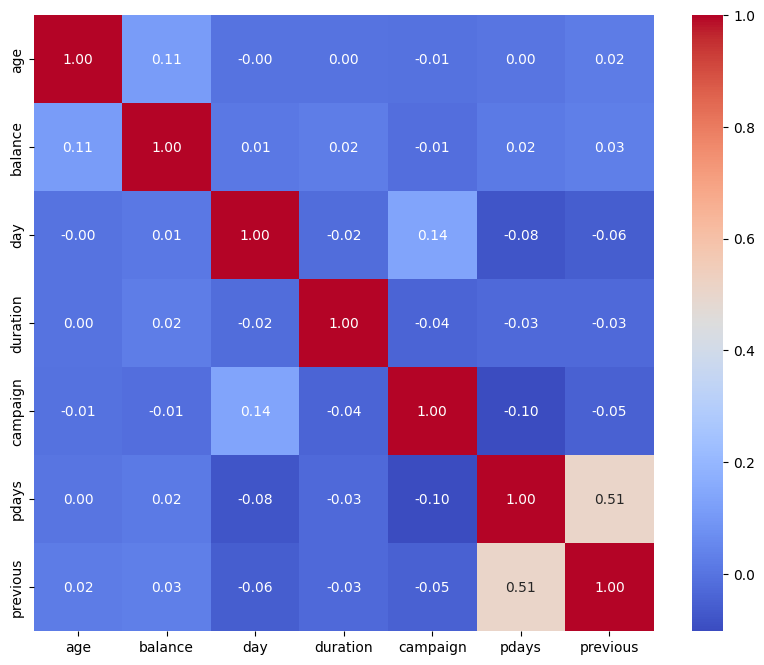

In [27]:
# Opcional: visualiza a matriz de correlação como um mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Gerando a matriz de dispersão:

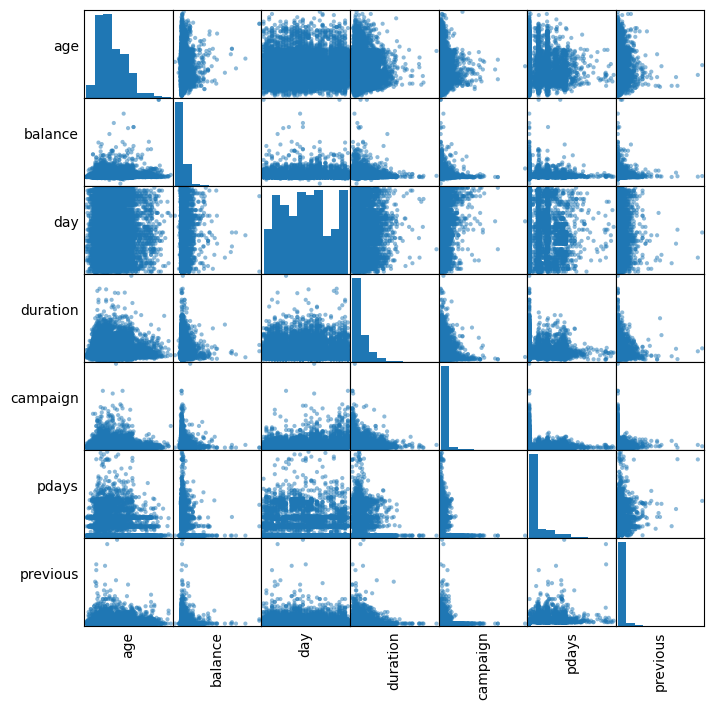

In [21]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [26]:
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Usando os dados para fazer previsão de cenários futuros

Vamos realizar a indexação e codificação de colunas categóricas de um DataFrame do PySpark. Primeiro, vamos importar as bibliotecas necessárias e define uma lista de colunas categóricas. Para cada coluna, vamos criar um `StringIndexer` que converte os valores categóricos em índices numéricos. Em seguida, usa um `OneHotEncoderEstimator` para transformar esses índices em vetores binários one-hot. Esses transformadores são armazenados em uma lista chamada `stages`, que será usada em um pipeline para aplicar essas transformações aos dados. O resultado final é um DataFrame com as colunas categóricas convertidas em vetores binários, facilitando a análise e o uso em algoritmos de aprendizado de máquina.

In [31]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + 'classVec')
    stages += [stringIndexer, encoder]

# Visualização do estágio
for stage in stages:
    print(stage)

StringIndexer_542057a63ce1
OneHotEncoder_29d0321f31bf
StringIndexer_d0ee5d93867a
OneHotEncoder_235f6c8f55b0
StringIndexer_110e000c7105
OneHotEncoder_d6d417d6ffae
StringIndexer_8dd09672383f
OneHotEncoder_b6fe1db8d2a4
StringIndexer_9896f3b6c173
OneHotEncoder_b491d0309705
StringIndexer_3b3f56df9f05
OneHotEncoder_c2ba1dce4035
StringIndexer_4e94cffbf0ef
OneHotEncoder_ae1435ab4f8c
StringIndexer_df86b9d65d00
OneHotEncoder_d69607603f0c


Usamos o StringIndexer novamente para codificar nossas etiquetas em índices de etiquetas. Em seguida, usamos o VectorAssembler para combinar todas as colunas de características em uma única coluna de vetor.

In [32]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

Pipeline

Usamos o Pipeline para encadear múltiplos Transformadores e Estimadores juntos para especificar nosso fluxo de trabalho de aprendizado de máquina. Os estágios de um Pipeline são especificados como um array ordenado.

In [33]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [34]:
pd.DataFrame(df.take(5), columns=df.columns)

,label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,no,2343,yes,no,unknown,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,no,45,no,no,unknown,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,no,1270,yes,no,unknown,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,no,2476,yes,no,unknown,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,no,184,no,no,unknown,673,2,-1,0,unknown,yes


Separando o conjunto em treino e teste.

In [35]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


### Criando um Modelo de Regressão Logística

In [36]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

Em um modelo de regressão logística, os gráficos "Beta Coefficients", "ROC Curve" e "Precision x Recall" servem para diferentes propósitos de análise e interpretação do desempenho do modelo:

1. **Beta Coefficients**:
   - **Propósito**: Este gráfico mostra os coeficientes estimados para cada variável independente (ou característica) no modelo de regressão logística.
   - **Interpretação**: Os coeficientes indicam a direção e a magnitude da associação entre as variáveis independentes e a variável dependente. Coeficientes positivos indicam que o aumento na variável independente está associado a um aumento na probabilidade do resultado, enquanto coeficientes negativos indicam o oposto.

2. **ROC Curve (Receiver Operating Characteristic Curve)**:
   - **Propósito**: Este gráfico é usado para avaliar a capacidade do modelo em distinguir entre as classes (por exemplo, positivo vs. negativo).
   - **Interpretação**: A curva ROC plota a taxa de verdadeiros positivos (sensibilidade) contra a taxa de falsos positivos (1 - especificidade) para diferentes limiares de classificação. A área sob a curva ROC (AUC) é uma medida do desempenho do modelo; quanto mais próximo de 1, melhor a capacidade de discriminação do modelo.

3. **Precision x Recall**:
   - **Propósito**: Este gráfico é usado para avaliar o equilíbrio entre a precisão (quantos dos exemplos classificados como positivos são realmente positivos) e a recall (quantos dos exemplos realmente positivos são classificados corretamente pelo modelo).
   - **Interpretação**: A curva de Precisão x Recall é especialmente útil em cenários de classes desbalanceadas, onde uma classe é muito mais frequente do que a outra. A análise desse gráfico ajuda a entender o trade-off entre precisão e recall e a escolher o limiar de decisão mais adequado para o problema em questão.

Em resumo:
- **Beta Coefficients**: Indicam a influência das variáveis independentes no modelo.
- **ROC Curve**: Avalia a capacidade do modelo de distinguir entre classes.
- **Precision x Recall**: Avalia o equilíbrio entre precisão e recall, especialmente útil para classes desbalanceadas.

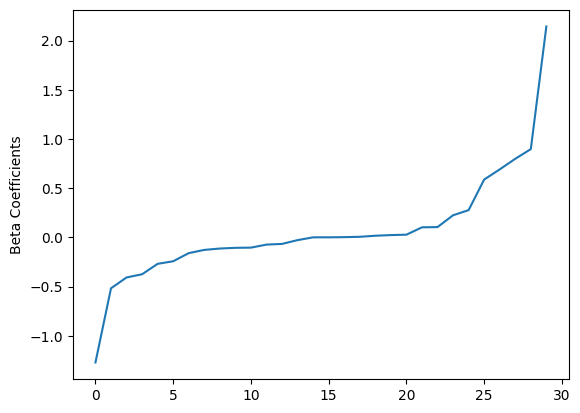

In [37]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

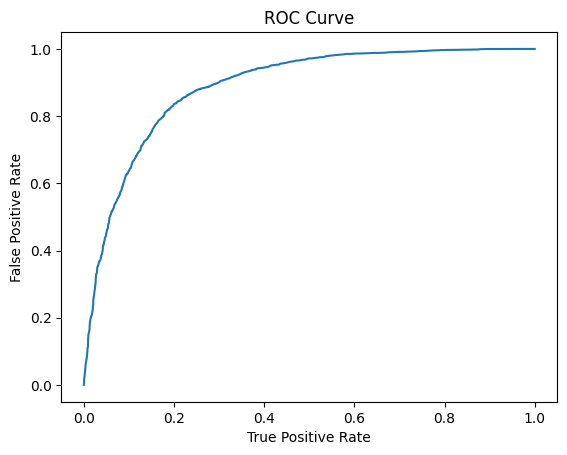

Training set areaUnderROC: 0.8877385690600346


In [38]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

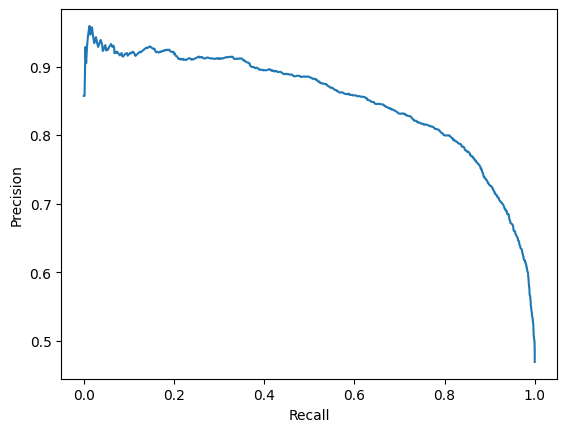

In [39]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [40]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93084854518128...|       0.0|[0.87334331124860...|
| 49|management|  0.0|[1.92783695472097...|       0.0|[0.87300981013433...|
| 52|management|  0.0|[-0.7737627890181...|       1.0|[0.31566570209267...|
| 53|management|  0.0|[0.94708137344074...|       0.0|[0.72052784002179...|
| 58|management|  0.0|[2.44657764692457...|       0.0|[0.92031082026376...|
| 32|management|  0.0|[1.28386077546037...|       0.0|[0.78310624913886...|
| 57|management|  0.0|[1.05745870556531...|       0.0|[0.74220460119091...|
| 52|management|  0.0|[3.25200815517462...|       0.0|[0.96274520587479...|
| 46|management|  0.0|[2.24978402804239...|       0.0|[0.90463190417562...|
| 31|management|  0.0|[1.47121751117284...|       0.0|[0.81324237120150...|
+---+-------